# INFO 2950 Project Phase II

## I. Research Questions

1. What socio-demographic factors influence incidence of mental illness?
2. What socio-demographic factors influence incidence of drug use?
3. How has incidence of mental illness changed over time?
4. How had incidence of illict drug changed over time?
5. Is there evidence of a relationship between incidence of mental illness and incidence of illicit drug use?

   


## II. Data Collecting and Cleaning

### A. Setup

Here is the setup part that imports everything needed throughout the rest of the notebook.  I copied the imports from homework 2 since they match what is needed here.

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} requests
!conda install --yes --prefix {sys.prefix} bs4


Solving environment: ...working... done

# All requested packages already installed.



In [1]:
import requests #package for http requests
import bs4 # package for html parsing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### B. "Library" 

Although it's not an actual separate library, I ended up creating a lot of functions and some variables to help me clean up the data and this section is where they all live.  A description of what the functions do can be found in their respective docstrings and the motivations for using them are specified in the next section which is where all of the actual data cleaning magic takes place.

In [2]:
def web_to_soup(web_address, file_name):
    """ 
    Returns a BeautufulSoup object containing the html from the webpage passed as the web_address argument and saves the
    content in a file named using the argument passed as file_name.
    
    web_address: string. The address of the webpage to get html from.
    
    file_name: string. The name of the file where the html from the website will be saved.
    """
    response = requests.get(web_address)
    soup = bs4.BeautifulSoup(response.text, 'html.parser')
    file = file_name
    with open(file, mode='w', encoding='utf-8') as f:
        f.write(response.text)
    return soup

In [3]:
def extract_categories(soup):
    """ 
    Returns a list of categories (strings with "th" tags whose class is either subhead1 or subhead2) from the left 
    side of the samhsa data tables where each index's entry is a string.
    
    soup: BeautifulSoup object containing the html from which the categories will be extracted.
    """
    search = soup.find_all("th",{"class":["subhead2","subhead1"]}) 
    categories = []
    for tag in search:
        categories.append(tag.text)
    categories = np.array(categories)
    return categories

In [4]:
def pull_out_data(soup):
    """
    Returns a list where each entry is a data entry (string with 'td' tag) from the html given by the BeautifulSoup 
    object passed as the soup argument.
    
    soup: BeautifulSoup object from which the data will be collected.
    """
    search = soup.find_all("td") 
    data_entries = []
    for tag in search:
        data_entries.append(tag.text)
    data_entries = np.array(data_entries)
    return data_entries

In [5]:
def delete_blank(data_array):
    """
    Returns a list of data identical to the argument passed to it but with '\xa0' entries removed.
    
    data_array: the list from which blank entries are to be deleted.
    """
    to_delete = []
    for i in range(len(data_array)):
        if data_array[i]=='\xa0':
            to_delete.append(i)
    data = np.delete(data_array, to_delete)
    return data

In [6]:
def delete_footnotes_and_commas(dataframe):
    """
    Returns a pandas DataFrame identical to the argument passed in dataframe but with 'a' and ',' removed from each string entry 
    in the DataFrame.
    
    dataframe: the pandas DataFrame from which 'a' and ',' will be deleted in all entries.
    """
    col_names = dataframe.columns.values.tolist()
    row_count = len(dataframe)
    for name in col_names:
        for i in range(row_count):
            if('a' in dataframe[name][i]):
                dataframe[name][i]=dataframe[name][i].replace('a', '')
            if(',' in dataframe[name][i]):
                dataframe[name][i]=dataframe[name][i].replace(',', '')
    return dataframe

In [7]:
def arrange_data(array, number_of_rows, number_of_columns):
    """
    Returns a 2D list with number_of_rows 1D lists each with number_of_columns entries.
    
    array: 1D list from which the data will be rearranged.
    
    number_of_rows: int. the number of rows that the returned 2D list will have.
    
    number_of_columns: int. the number of columns that the returned 2D list will have.
    """
    formatted_data=[]
    count=0
    for i in range(number_of_rows):
        formatted_data.append(array[count:count+number_of_columns:1])
        count+=number_of_columns
    return formatted_data

In [8]:
def to_numbers(dataframe):
    """
    Returns a pandas DataFrame with all entries turned into numeric datatypes (ints, floats).  If an entry cannot be converted
    into a numerica data type, it will replace the entry with NaN.
    
    dataframe: the pandas DataFrame on which the operation described above will be performed.
    """
    col_names = dataframe.columns.values.tolist()
    row_count = len(dataframe)
    for name in col_names:
        for i in range(row_count):
            dataframe[name][i]=pd.to_numeric(dataframe[name][i], 'coerce')
    return dataframe

In [9]:
years1 = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
years2 = ['2002', '2003', '2004', '2005', '2006', '2007','2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
ages1 = ['aged_12+_2018', 'aged_12+_2019','aged_12-17_2018', 'aged_12-17_2019','aged_18+_2018','aged_18+_2019', 'aged_18-25_2018','aged_18-25_2019', 'aged_26+_2018', 'aged_26+_2019']
ages2 = ['aged_18+_2018', 'aged_18+_2019','aged_18-25_2018', 'aged_18-25_2019','aged_26+_2018','aged_26+_2019', 'aged_26-49_2018','aged_26-49_2019', 'aged_50+_2018', 'aged_50+_2019']



### C. Data Cleaning Time!

First, I put all of the actual web scraping code in a cell of its own since it took a few seconds for the content of each page to be gathered and I wanted to make that a one-and-done task.  I used the function web_to_soup() that I wrote above to get the html content from the website specified in the argument web_address.  This function also dumps the html into a file whose name is given in the argument file_name.


In [10]:
soup1=web_to_soup('https://www.samhsa.gov/data/sites/default/files/reports/rpt29394/NSDUHDetailedTabs2019/NSDUHDetTabsSect10pe2019.htm', 'samhsa1.html')
soup2=web_to_soup('https://www.samhsa.gov/data/sites/default/files/reports/rpt29394/NSDUHDetailedTabs2019/NSDUHDetTabsSect11pe2019.htm', 'samhsa2.html')
soup3=web_to_soup('https://www.samhsa.gov/data/sites/default/files/reports/rpt29394/NSDUHDetailedTabs2019/NSDUHDetTabsSect1pe2019.htm', 'samhsa3.html')

Since our project incorporates a lot of different data from a lot of different data tables that don't intuitively merge well, I created a dictionary to store a description of the information provided by each DataFrame (see below).

In [80]:
what_it_do = {'df2':'Any Mental Illness in Past Year among Persons Aged 18 or Older, by Demographic Characteristics: Percentages: 2008-2019', 
              'df5':'Illicit drug use percent by demographic, 2009-2019', 
              'df6':'Mental illness percent by age group and demographic',
              'df7':'Illicit Drug Use in Past Year among Persons Aged 18 or Older, by Demographic Characteristics: Percentages: 2009-2019',
              'df_geosoc':'Any Mental Illness in Past Year among Persons Aged 18 or Older, by Geographic and Socioeconomic Characteristics: Percentages: 2008-2019',
              'df_geosoc_drug': 'Illicit Drug Use in Past Year among Persons Aged 12 or Older, by Geographic and Socioeconomic Characteristics: Percentages: 2008-2019'
             }

Below, I use the BeautifulSoup objects I created along with the variables and functions I wrote above in the "Library" section in order to clean the data and get it ready for analyzing. I did this by first extracting the categories from the left side and top of the SAMHSA tables from the html given by the BeautifulSoup object (and adding entries as necessary if any of them didn't get picked up from the original table due to having different html tags than the extract_categories() function above searches for) and collecting the actual entries in the data table.  Next, I format the data so it has the right number of columns and rows, create a pandas DataFrame with it, add index and column labels, delete footnotes and commas, turn the data entries from strings into numeric entries (replacing non-covertable entries with NaN), and lastly transpose the DataFrame so that we can run analyses using the columns.

We made the conscious decision to replace missing numeric values with NaN since this would allow us to later perform analyses on all columns, even the ones containing missing entries.  For example, the .corr() method automatically works even if a column contains NaN entries.

Please note that DataFrames are labeled dfx where x is a number.  The DataFrames were originally labeled sequentially (df1, df2, ...) but some DataFrames were deleted due to having unneeded data.

In [52]:
demographics = extract_categories(soup1)
demographics2 = demographics[14:28]
demographics2 = np.insert(demographics2,0,"total")
data2=pull_out_data(soup1)
data2
data2 = data2[216:432]
data2 = delete_blank(data2)
data2_formatted = arrange_data(data2, 15, 12)
df2 = pd.DataFrame(data2_formatted, demographics2, years1)
df2 = delete_footnotes_and_commas(df2)
df2 = df2.transpose()
df2 = to_numbers(df2)
print(what_it_do['df2'])
df2


Any Mental Illness in Past Year among Persons Aged 18 or Older, by Demographic Characteristics: Percentages: 2008-2019


,total,18-25,26 or Older,26-49,50 or Older,Male,Female,Not Hispanic or Latino,White,Black or African American,AIAN,NHOPI,Asian,Two or More Races,Hispanic or Latino
2008,17.7,18.5,17.6,20.7,14.1,13.6,21.5,18,18.3,16.7,17.3,NaN,13.3,26.5,16
2009,18.1,18,18.2,21.6,14.5,14.2,21.8,18.5,19.2,15.6,20,NaN,12.8,31.1,15.7
2010,18.1,18.1,18.1,20.9,15.1,14.8,21.1,18.5,19,16.9,17.4,NaN,13.7,22,15.2
2011,17.8,18.5,17.7,20.3,15,14.2,21.1,18.5,19,16.3,27.7,NaN,13.1,25.8,13.5
2012,18.6,19.6,18.4,21.2,15.8,14.9,22,19,19.3,18.6,28.3,NaN,13.9,20.7,16.3
2013,18.5,19.4,18.3,21.5,15.3,14.4,22.3,18.7,19.3,16.9,26,14.4,12.3,28.1,16.9
2014,18.1,20.1,17.8,20.4,15.4,14.1,21.8,18.6,19.2,16.3,21.2,22.3,13.1,27.1,15.6
2015,17.9,21.7,17.2,20.9,14,14.3,21.2,18.5,19.3,15.4,21.2,14.8,12,29.5,14.5
2016,18.3,22.1,17.6,21.1,14.5,14.5,21.7,18.7,19.9,14.5,22.8,16.7,12.1,26.5,15.7
2017,18.9,25.8,17.8,22.2,13.8,15.1,22.3,19.6,20.4,16.2,18.9,19.4,14.5,28.6,15.2


In [63]:
demographics_geosoc = extract_categories(soup1)
demographics_geosoc = demographics_geosoc[32:49]
demographics_geosoc = np.insert(demographics_geosoc,0,"total")
data_geosoc =pull_out_data(soup1)
data_geosoc = data_geosoc[756:1080]
data_geosoc = delete_blank(data_geosoc)
data_geosoc_formatted = arrange_data(data_geosoc, 18, 12)
df_geosoc = pd.DataFrame(data_geosoc_formatted, demographics_geosoc, years1)
df_geosoc = delete_footnotes_and_commas(df_geosoc)
df_geosoc = df_geosoc.transpose()
df_geosoc = to_numbers(df_geosoc)
print(what_it_do['df_geosoc'])
df_geosoc

Any Mental Illness in Past Year among Persons Aged 18 or Older, by Geographic and Socioeconomic Characteristics: 2008-2019


,total,Large Metro,Small Metro,Nonmetro,Urbanized,Less Urbanized,Completely Rural,Less Than 100%,100-199%,200% or More,< High School,High School Graduate,Some College/Associate's Degree,College Graduate,Private,Medicaid/CHIP,Other5,No Coverage
2008,17.7,18.9,18.4,17,17.3,17.1,18.5,18.1,18.8,17.7,17.6,25.2,21.6,15.5,NaN,NaN,NaN,NaN
2009,18.1,18,18.4,17.6,18.8,17.8,18.6,18.4,17.1,19.8,17.2,25.1,20.2,16.3,NaN,NaN,NaN,NaN
2010,18.1,18.7,18.7,17.4,17.9,17.4,18.8,18.9,17.9,19.5,20.8,24.7,20.5,16,NaN,NaN,NaN,NaN
2011,17.8,16.3,18,17.9,18.6,16.8,19,18.9,20.2,18.8,14.2,25.8,20.5,15.2,NaN,NaN,NaN,NaN
2012,18.6,18,18.2,18.7,19.3,18,19.6,18.6,18.6,19,16.6,26.8,21.8,15.6,NaN,NaN,NaN,NaN
2013,18.5,17.8,18.6,18.2,19.3,18.2,18.7,18.8,19.2,19.1,15.9,26.1,20.9,16,NaN,NaN,NaN,NaN
2014,18.1,17.6,18.5,17.8,18.8,17.3,18.8,20.1,20.5,19.9,19.7,25.7,21.4,15.4,NaN,NaN,NaN,NaN
2015,17.9,17.6,17.9,17.9,18,17.3,18.7,18.3,19.4,17.5,17.1,24.4,19.7,15.8,16.9,17.2,20.9,15.8
2016,18.3,18.1,17.4,18.1,19.4,17.6,19.2,18.7,17.7,19.8,17.6,24.5,21.8,15.7,17.2,17.7,20.8,16.6
2017,18.9,18,19.8,18.1,19.9,18.2,20.1,19.1,19.5,18.7,19.1,25.6,20.8,16.8,17.3,17.3,21.5,18.1


In [14]:
demographics3 = extract_categories(soup3)
demographics3 = demographics3.tolist()
itemindex = demographics3.index('Male')
demographics3 = demographics3[itemindex:itemindex+18]
demographics3 = np.asarray(demographics3)
data5 = pull_out_data(soup3)
data5 = data5.tolist()
#data5.index('49.2a')
data5 = data5[5882:5882+230]
data5=delete_blank(data5)
data5_formatted = arrange_data(data5, 18, 10)
df5 = pd.DataFrame(data5_formatted, demographics3, ages1)
df5=delete_footnotes_and_commas(df5)
df5 = to_numbers(df5)
df5 = df5.transpose()
print(what_it_do['df5'])
df5


Illicit drug use percent by demographic, 2009-2019


,Male,Female,Not Hispanic or Latino,White,Black or African American,AIAN,NHOPI,Asian,Two or More Races,Hispanic or Latino,< High School,High School Graduate,Some College/Associate's Degree,College Graduate,Full-Time,Part-Time,Unemployed,Other1
aged_12+_2018,49.2,53.6,45.1,51.6,54.5,45.9,60.8,47.7,27.6,61.4,37.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aged_12+_2019,50.2,54.2,46.3,52.2,55.6,46.9,55.7,44,24,62.6,40.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aged_12-17_2018,23.9,23.8,24,23.5,23.4,26.2,28.4,NaN,13.7,28.7,25.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aged_12-17_2019,24.5,23.8,25.2,24.1,24.3,25.5,37.5,NaN,12.9,27.9,25.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aged_18+_2018,51.8,56.7,47.2,54.1,57.1,48.2,64.2,49.2,29,67.4,39.6,37.5,47.7,57.8,54.6,58.2,54.4,57.8
aged_18+_2019,52.7,57.4,48.3,54.8,58.2,49.3,58,45.5,24.9,70,42.3,40.8,49.2,58.9,53.9,58.5,55.8,57.6
aged_18-25_2018,55.6,56.2,54.9,56.6,59.6,53.1,56,NaN,36.8,68.7,52,47.7,53.1,58.9,59.1,60.4,55.1,58.4
aged_18-25_2019,55.8,55.9,55.7,57.1,60.4,52.8,64,NaN,35.3,64,51.6,50,52.1,58.3,62.7,62.9,54.4,53.1
aged_26+_2018,51.2,56.8,46,53.8,56.8,47.2,65.6,NaN,27.5,67.1,36.8,35.7,46.6,57.6,54.3,58,54.2,57.5
aged_26+_2019,52.2,57.7,47.2,54.4,57.9,48.6,56.8,46.4,23.2,71.6,40.2,39.1,48.6,59,53.3,57.9,56.3,59.8


The data below was entered manually because the way it was written in the html file was out of order and there was no logical way to extract it directly.  Instead, we decided that copying and pasting it directly from the data table was the best option.

In [15]:
## data is from the following set of tables: https://www.samhsa.gov/data/sites/default/files/reports/rpt29394/NSDUHDetailedTabs2019/NSDUHDetTabsSect8pe2019.htm

data6=[]
data6.append([19.1,20.6,6.3,29.4,18.0,19.2,22.5,25.0,14.0,14.1])
data6.append([15.2,16.3,20.6,22.8,14.3,15.3,18.1,19.8,10.8,11.2])
data6.append([22.8,24.5,32.0,36.1,21.4,22.8,26.8,30.0,16.9,16.7])
data6.append([19.6,21.1,27.7,31.0,18.4,19.7,23.7,26.6,14.2,14.2])
data6.append([20.4,22.2,29.9,33.4,19.2,20.7,26.1,29.2,14.3,14.8])
data6.append([16.2,17.3,20.4,23.8,15.4,16.1,16.8,20.3,14.0,11.7])
data6.append([22.1,18.7,22.6,23.6,22.0,17.7,26.1,22.1,np.NaN,np.NaN])
data6.append([21.1,16.6,np.NaN,np.NaN,np.NaN,15.1,np.NaN,20.2,np.NaN,np.NaN])
data6.append([14.7,14.4,23.7,24.6,13.0,12.7,16.0,15.7,7.8,8.6])
data6.append([26.8,31.7,37.0,39.3,24.6,29.6,29.2,36.3,21.4,20.8])
data6.append([16.9,18.0,21.3,24.0,15.9,16.7,17.6,18.5,13.0,13.7])
data6.append([17.6,19.2,25.0,28.2,16.7,18.0,19.6,22.3,11.7,10.7])
data6.append([22.0,25.0,29.5,34.6,19.3,21.7,26.6,30.8,13.0,14.4])
data6.append([27.6,27.7,27.9,27.2,27.4,27.9,29.2,30.7,23.7,22.9])
data6.append([19.3,20.1,24.5,27.1,18.7,19.4,29.4,30.4,15.5,16.1])

demographics4 = demographics3
demographics4[10]='Full Time'
demographics4[11]='Part Time'
demographics4[12]='Unemployed'
demographics4[13]='Other'
demographics4=demographics4[:14]
demographics4=np.asarray(demographics4)
demographics4=np.insert(demographics4,0,"total")

df6 = pd.DataFrame(data6, demographics4, ages2)

df6 = df6.transpose()
print(what_it_do['df6'])
df6

Mental illness percent by age group and demographic


,total,Male,Female,Not Hispanic or Latino,White,Black or African American,AIAN,NHOPI,Asian,Two or More Races,Hispanic or Latino,Full Time,Part Time,Unemployed,Other
aged_18+_2018,19.1,15.2,22.8,19.6,20.4,16.2,22.1,21.1,14.7,26.8,16.9,17.6,22.0,27.6,19.3
aged_18+_2019,20.6,16.3,24.5,21.1,22.2,17.3,18.7,16.6,14.4,31.7,18.0,19.2,25.0,27.7,20.1
aged_18-25_2018,6.3,20.6,32.0,27.7,29.9,20.4,22.6,NaN,23.7,37.0,21.3,25.0,29.5,27.9,24.5
aged_18-25_2019,29.4,22.8,36.1,31.0,33.4,23.8,23.6,NaN,24.6,39.3,24.0,28.2,34.6,27.2,27.1
aged_26+_2018,18.0,14.3,21.4,18.4,19.2,15.4,22.0,NaN,13.0,24.6,15.9,16.7,19.3,27.4,18.7
aged_26+_2019,19.2,15.3,22.8,19.7,20.7,16.1,17.7,15.1,12.7,29.6,16.7,18.0,21.7,27.9,19.4
aged_26-49_2018,22.5,18.1,26.8,23.7,26.1,16.8,26.1,NaN,16.0,29.2,17.6,19.6,26.6,29.2,29.4
aged_26-49_2019,25.0,19.8,30.0,26.6,29.2,20.3,22.1,20.2,15.7,36.3,18.5,22.3,30.8,30.7,30.4
aged_50+_2018,14.0,10.8,16.9,14.2,14.3,14.0,NaN,NaN,7.8,21.4,13.0,11.7,13.0,23.7,15.5
aged_50+_2019,14.1,11.2,16.7,14.2,14.8,11.7,NaN,NaN,8.6,20.8,13.7,10.7,14.4,22.9,16.1


Below, I gathered data from 2009 to 2019 on the percent of people by demographic who have used illicit drugs in the last year.  I did this by looking up the SAMHSA table corresponding to this variable for every year since 2009.  Many of the tables throughout the years have different HTML code and tags, making it very impractical and almost impossible to write code to automatically extract the data.  Instead of automatically writing the data to a DataFrame as I did for the first two DataFrames above, I copied and pasted the entries directly from the SAMHSA data tables into a DataFrame by first creating a DataFrame of the right size with the right labels where all entries are None.  I then go through and fill in the data.  Although I don't make use of a BeautifulSoup object to make this DataFrame, I still used the function web_to_soup() so that all of the data is saved in a local file.

In [16]:
samhsa5=web_to_soup('https://www.samhsa.gov/data/sites/default/files/reports/rpt29394/NSDUHDetailedTabs2019/NSDUHDetTabsSect1pe2019.htm', 'samhsa5.html')
samhsa6=web_to_soup('https://www.samhsa.gov/data/sites/default/files/cbhsq-reports/NSDUHDetailedTabs2018R2/NSDUHDetTabsSect1pe2018.htm', 'samhsa6.html')
samhsa7=web_to_soup('https://www.samhsa.gov/data/report/results-2016-national-survey-drug-use-and-health-detailed-tables', 'samhsa7.html')
samhsa8=web_to_soup('https://www.samhsa.gov/data/report/results-2014-national-survey-drug-use-and-health-detailed-tables', 'samhsa8.html')
samhsa9=web_to_soup('https://www.samhsa.gov/data/report/results-2012-national-survey-drug-use-and-health-detailed-tables-table-contents', 'samhsa9.html')
samhsa10=web_to_soup('https://www.samhsa.gov/data/report/results-2010-national-survey-drug-use-and-health-detailed-tables', 'samhsa10.html')

In [81]:
filler = [None]*(110)
df7 = pd.DataFrame(arrange_data(filler, 11, 10), years1[1:], ['total','Male', 'Female', 'White', 'Black or African American', 'AIAN', 'NHOPI', 'Asian', 'Two or More Races','Hispanic or Latino'])

## Illicit Drug Use in Past Year among Persons Aged 12 or Older, by Age Group and Demographic Characteristics: Percentages
## 2019: https://www.samhsa.gov/data/sites/default/files/reports/rpt29394/NSDUHDetailedTabs2019/NSDUHDetTabsSect1pe2019.htm

df7['total']['2019']=21.1
df7['Male']['2019']=24.5
df7['Female']['2019']=18.0
df7['White']['2019']=22.1
df7['Black or African American']['2019']=22.4
df7['AIAN']['2019']=24.7
df7['NHOPI']['2019']=15.6
df7['Asian']['2019']=10.3
df7['Two or More Races']['2019']=34.3
df7['Hispanic or Latino']['2019']=19.1

## 2018 & 2017: https://www.samhsa.gov/data/sites/default/files/cbhsq-reports/NSDUHDetailedTabs2018R2/NSDUHDetTabsSect1pe2018.htm

df7['total']['2018']=19.7
df7['total']['2017']=19.3
df7['Male']['2018']=22.7
df7['Male']['2017']=22.7
df7['Female']['2018']=16.9
df7['Female']['2017']=16.2
df7['White']['2018']=20.5
df7['White']['2017']=20.0
df7['Black or African American']['2018']=21.2
df7['Black or African American']['2017']=20.9
df7['AIAN']['2018']=29.6
df7['AIAN']['2017']=29.5
df7['NHOPI']['2018']=21.6
df7['NHOPI']['2017']=13.0
df7['Asian']['2018']=11.5
df7['Asian']['2017']=9.8
df7['Two or More Races']['2018']=27.1
df7['Two or More Races']['2017']=28.6
df7['Hispanic or Latino']['2018']=17.1
df7['Hispanic or Latino']['2017']=17.6

## 2016 & 2015: https://www.samhsa.gov/data/report/results-2016-national-survey-drug-use-and-health-detailed-tables

df7['total']['2016']=18.2
df7['total']['2015']=17.9
df7['Male']['2015']=20.9
df7['Male']['2016']=21.3
df7['Female']['2016']=15.4
df7['Female']['2015']=15.1
df7['White']['2016']=18.7
df7['White']['2015']=17.9
df7['Black or African American']['2016']=20.4
df7['Black or African American']['2015']=21.0
df7['AIAN']['2016']=23.8
df7['AIAN']['2015']=23.7
df7['NHOPI']['2016']=16.5
df7['NHOPI']['2015']=19.5
df7['Asian']['2016']=9.1
df7['Asian']['2015']=9.3
df7['Two or More Races']['2016']=31.7
df7['Two or More Races']['2015']=28.1
df7['Hispanic or Latino']['2016']=16.1
df7['Hispanic or Latino']['2015']=17.0

## 2014 & 2013: https://www.samhsa.gov/data/report/results-2014-national-survey-drug-use-and-health-detailed-tables table 1.23B

df7['total']['2014']=16.6
df7['total']['2013']=15.7
df7['Male']['2014']=20.2
df7['Male']['2013']=18.7
df7['Female']['2014']=13.2
df7['Female']['2013']=12.9
df7['White']['2014']=16.8
df7['White']['2013']=15.1
df7['Black or African American']['2014']=19.5
df7['Black or African American']['2013']=16.4
df7['AIAN']['2014']=24.1
df7['AIAN']['2013']=26.7
df7['NHOPI']['2014']=22.2
df7['NHOPI']['2013']=20.5
df7['Asian']['2014']=7.8
df7['Asian']['2013']=6.8
df7['Two or More Races']['2014']=24.2
df7['Two or More Races']['2013']=29.3
df7['Hispanic or Latino']['2014']=15.0
df7['Hispanic or Latino']['2013']=14.7

## 2012 & 2011: https://www.samhsa.gov/data/report/results-2012-national-survey-drug-use-and-health-detailed-tables-table-contents table 1.23B

df7['total']['2012']=15.7
df7['total']['2011']=14.4
df7['Male']['2012']=19.0
df7['Male']['2011']=17.5
df7['Female']['2012']=12.7
df7['Female']['2011']=11.6
df7['White']['2012']=15.7
df7['White']['2011']=14.7
df7['Black or African American']['2012']=18.6
df7['Black or African American']['2011']=15.5
df7['AIAN']['2012']=25.0
df7['AIAN']['2011']=24.0
df7['NHOPI']['2012']=18.2
df7['NHOPI']['2011']='*'
df7['Asian']['2012']=7.6
df7['Asian']['2011']=7.0
df7['Two or More Races']['2012']=21.4
df7['Two or More Races']['2011']=22.0
df7['Hispanic or Latino']['2012']=15.2
df7['Hispanic or Latino']['2011']=13.7

## 2010 & 2009: https://www.samhsa.gov/data/report/results-2010-national-survey-drug-use-and-health-detailed-tables table 1.23B

df7['total']['2010']=14.9
df7['total']['2009']=14.6
df7['Male']['2010']=18.1
df7['Male']['2009']=17.6
df7['Female']['2010']=11.8
df7['Female']['2009']=11.8
df7['White']['2010']=15.0
df7['White']['2009']=14.9
df7['Black or African American']['2010']=16.4
df7['Black or African American']['2009']=15.3
df7['AIAN']['2010']=21.9
df7['AIAN']['2009']=26.8
df7['NHOPI']['2010']=10.6
df7['NHOPI']['2009']='*'
df7['Asian']['2010']=8.6
df7['Asian']['2009']=5.8
df7['Two or More Races']['2010']=22.3
df7['Two or More Races']['2009']=23.3
df7['Hispanic or Latino']['2010']=14.2
df7['Hispanic or Latino']['2009']=14.0

df7 = to_numbers(df7)
print(what_it_do['df7'])
df7

Illicit Drug Use in Past Year among Persons Aged 18 or Older, by Demographic Characteristics: Percentages: 2009-2019


,total,Male,Female,White,Black or African American,AIAN,NHOPI,Asian,Two or More Races,Hispanic or Latino
2009,14.6,17.6,11.8,14.9,15.3,26.8,NaN,5.8,23.3,14
2010,14.9,18.1,11.8,15,16.4,21.9,10.6,8.6,22.3,14.2
2011,14.4,17.5,11.6,14.7,15.5,24,NaN,7,22,13.7
2012,15.7,19,12.7,15.7,18.6,25,18.2,7.6,21.4,15.2
2013,15.7,18.7,12.9,15.1,16.4,26.7,20.5,6.8,29.3,14.7
2014,16.6,20.2,13.2,16.8,19.5,24.1,22.2,7.8,24.2,15
2015,17.9,20.9,15.1,17.9,21,23.7,19.5,9.3,28.1,17
2016,18.2,21.3,15.4,18.7,20.4,23.8,16.5,9.1,31.7,16.1
2017,19.3,22.7,16.2,20,20.9,29.5,13,9.8,28.6,17.6
2018,19.7,22.7,16.9,20.5,21.2,29.6,21.6,11.5,27.1,17.1


In [84]:
filler = [None]*(110)
df_geosoc_drug = pd.DataFrame(arrange_data(filler, 11, 14), years1[1:], ['total','Large Metro', 'Small Metro', 'Nonmetro', 'Urbanized', 'Less Urbanized',
                                                                         'Completely Rural', 'Less than 100%', '100%-199%', '200% or More', 'Private',
                                                                         'Medicaid/CHIP', 'Other', 'No Coverage'])

## Illicit Drug Use in Past Year among Persons Aged 12 or Older, by Geographic and Socioeconomic Characteristics: Percentages
## 2019 & 2018: https://www.samhsa.gov/data/sites/default/files/reports/rpt29394/NSDUHDetailedTabs2019/NSDUHDetTabsSect1pe2019.htm Table 1.64B

df_geosoc_drug['total']['2019']=20.8
df_geosoc_drug['Large Metro']['2019']=22.0
df_geosoc_drug['Small Metro']['2019']=20.5
df_geosoc_drug['Nonmetro']['2019']=16.6
df_geosoc_drug['Urbanized']['2019']=19.0
df_geosoc_drug['Less Urbanized']['2019']=15.1
df_geosoc_drug['Completely Rural']['2019']=14.2
df_geosoc_drug['Less than 100%']['2019']=25.9
df_geosoc_drug['100%-199%']['2019']=22.4
df_geosoc_drug['200% or More']['2019']=19.2
df_geosoc_drug['Private']['2019']=18.7
df_geosoc_drug['Medicaid/CHIP']['2019']=28.4
df_geosoc_drug['Other']['2019']=12.6
df_geosoc_drug['No Coverage']['2019']=28.3

df_geosoc_drug['total']['2018']=19.4
df_geosoc_drug['Large Metro']['2018']=20.2
df_geosoc_drug['Small Metro']['2018']=19.8
df_geosoc_drug['Nonmetro']['2018']=15.7
df_geosoc_drug['Urbanized']['2018']=17.1
df_geosoc_drug['Less Urbanized']['2018']=15.0
df_geosoc_drug['Completely Rural']['2018']=12.5
df_geosoc_drug['Less than 100%']['2018']=23.9
df_geosoc_drug['100%-199%']['2018']=19.6
df_geosoc_drug['200% or More']['2018']=18.3
df_geosoc_drug['Private']['2018']=17.6
df_geosoc_drug['Medicaid/CHIP']['2018']=24.4
df_geosoc_drug['Other']['2018']=11.0
df_geosoc_drug['No Coverage']['2018']=28.3



## 2017 & 2016: https://www.samhsa.gov/data/sites/default/files/cbhsq-reports/NSDUHDetailedTabs2017/NSDUHDetailedTabs2017.htm Table 1.67B
df_geosoc_drug['total']['2017']=19.0
df_geosoc_drug['Large Metro']['2017']=19.9
df_geosoc_drug['Small Metro']['2017']=18.9
df_geosoc_drug['Nonmetro']['2017']=15.8
df_geosoc_drug['Urbanized']['2017']=17.0
df_geosoc_drug['Less Urbanized']['2017']=15.0
df_geosoc_drug['Completely Rural']['2017']= 14.2
df_geosoc_drug['Less than 100%']['2017']=24.4
df_geosoc_drug['100%-199%']['2017']=19.5
df_geosoc_drug['200% or More']['2017']=17.6
df_geosoc_drug['Private']['2017']=17.4
df_geosoc_drug['Medicaid/CHIP']['2017']=25.1
df_geosoc_drug['Other']['2017']=10.5
df_geosoc_drug['No Coverage']['2017']=27.2

df_geosoc_drug['total']['2016']=18.0
df_geosoc_drug['Large Metro']['2016']=19.4
df_geosoc_drug['Small Metro']['2016']=17.3
df_geosoc_drug['Nonmetro']['2016']=14.2
df_geosoc_drug['Urbanized']['2016']=15.4
df_geosoc_drug['Less Urbanized']['2016']=13.6
df_geosoc_drug['Completely Rural']['2016']=12.3
df_geosoc_drug['Less than 100%']['2016']=22.9
df_geosoc_drug['100%-199%']['2016']=18.6
df_geosoc_drug['200% or More']['2016']=16.6
df_geosoc_drug['Private']['2016']=15.9
df_geosoc_drug['Medicaid/CHIP']['2016']=24.2
df_geosoc_drug['Other']['2016']=10.3
df_geosoc_drug['No Coverage']['2016']=26.3

## 2015:https://www.samhsa.gov/data/sites/default/files/NSDUH-DetTabs-2016/NSDUH-DetTabs-2016.htm#tab1-67B Table 1.67B


df_geosoc_drug['total']['2015']=17.8
df_geosoc_drug['Large Metro']['2015']=19.0
df_geosoc_drug['Small Metro']['2015']=17.2
df_geosoc_drug['Nonmetro']['2015']=14.4
df_geosoc_drug['Urbanized']['2015']=16.5
df_geosoc_drug['Less Urbanized']['2015']=13.5
df_geosoc_drug['Completely Rural']['2015']=10.8
df_geosoc_drug['Less than 100%']['2015']=22.7
df_geosoc_drug['100%-199%']['2015']=18.9
df_geosoc_drug['200% or More']['2015']=16.2
df_geosoc_drug['Private']['2015']=15.7
df_geosoc_drug['Medicaid/CHIP']['2015']=23.3
df_geosoc_drug['Other']['2015']=9.9
df_geosoc_drug['No Coverage']['2015']=25.9

## 2014 & 2013: https://www.samhsa.gov/data/sites/default/files/NSDUH-DetTabs2014/NSDUH-DetTabs2014.htm#tab1-59b

df_geosoc_drug['total']['2014']= 16.7
df_geosoc_drug['Large Metro']['2014']= 17.4
df_geosoc_drug['Small Metro']['2014']= 16.5
df_geosoc_drug['Nonmetro']['2014']= 14.3
df_geosoc_drug['Urbanized']['2014']= 16.2
df_geosoc_drug['Less Urbanized']['2014']=13.8
df_geosoc_drug['Completely Rural']['2014']= 8.5
df_geosoc_drug['Less than 100%']['2014']
df_geosoc_drug['100%-199%']['2014']
df_geosoc_drug['200% or More']['2014']
df_geosoc_drug['Private']['2014']
df_geosoc_drug['Medicaid/CHIP']['2014']
df_geosoc_drug['Other']['2014']
df_geosoc_drug['No Coverage']['2014']

df_geosoc_drug['total']['2013']=15.9
df_geosoc_drug['Large Metro']['2013']= 16.3
df_geosoc_drug['Small Metro']['2013']= 16.5
df_geosoc_drug['Nonmetro']['2013']=13.1
df_geosoc_drug['Urbanized']['2013']= 15.0
df_geosoc_drug['Less Urbanized']['2013']=11.9
df_geosoc_drug['Completely Rural']['2013']= 10.2
df_geosoc_drug['Less than 100%']['2013']
df_geosoc_drug['100%-199%']['2013']
df_geosoc_drug['200% or More']['2013']
df_geosoc_drug['Private']['2013']
df_geosoc_drug['Medicaid/CHIP']['2013']
df_geosoc_drug['Other']['2013']
df_geosoc_drug['No Coverage']['2013']

## 2012: https://www.samhsa.gov/data/report/results-2012-national-survey-drug-use-and-health-detailed-tables-table-contents Table 1.59B


df_geosoc_drug['total']['2012'] = 16.0
df_geosoc_drug['Large Metro']['2012'] = 17.1
df_geosoc_drug['Small Metro']['2012']= 15.8
df_geosoc_drug['Nonmetro']['2012'] = 12.5
df_geosoc_drug['Urbanized']['2012'] = 14.5
df_geosoc_drug['Less Urbanized']['2012'] = 11.5
df_geosoc_drug['Completely Rural']['2012'] = 8.5
df_geosoc_drug['Less than 100%']['2012']
df_geosoc_drug['100%-199%']['2012']
df_geosoc_drug['200% or More']['2012']
df_geosoc_drug['Private']['2012']
df_geosoc_drug['Medicaid/CHIP']['2012']
df_geosoc_drug['Other']['2012']
df_geosoc_drug['No Coverage']['2012']


## 2011 & 2010: https://www.samhsa.gov/data/sites/default/files/NSDUH-DetTabsPDFWHTML2011-web/NSDUH-DetTabsPDFWHTML2011/HTML/NSDUH-DetTabsSect1peTabs47to92-2011.htm#Tab1.59B Table 1.59B
df_geosoc_drug['total']['2011']= 14.9
df_geosoc_drug['Large Metro']['2011']= 15.7
df_geosoc_drug['Small Metro']['2011']= 14.8
df_geosoc_drug['Nonmetro']['2011']= 12.2
df_geosoc_drug['Urbanized']['2011']= 14.4
df_geosoc_drug['Less Urbanized']['2011']= 10.7
df_geosoc_drug['Completely Rural']['2011']= 10.3
df_geosoc_drug['Less than 100%']['2011']
df_geosoc_drug['100%-199%']['2011']
df_geosoc_drug['200% or More']['2011']
df_geosoc_drug['Private']['2011']
df_geosoc_drug['Medicaid/CHIP']['2011']
df_geosoc_drug['Other']['2011']
df_geosoc_drug['No Coverage']['2011']

df_geosoc_drug['total']['2010']= 15.3
df_geosoc_drug['Large Metro']['2010']= 16.2
df_geosoc_drug['Small Metro']['2010']= 15.3
df_geosoc_drug['Nonmetro']['2010']= 12.5
df_geosoc_drug['Urbanized']['2010']= 13.6
df_geosoc_drug['Less Urbanized']['2010']= 12.5
df_geosoc_drug['Completely Rural']['2010']= 7.9
df_geosoc_drug['Less than 100%']['2010']
df_geosoc_drug['100%-199%']['2010']
df_geosoc_drug['200% or More']['2010']
df_geosoc_drug['Private']['2010']
df_geosoc_drug['Medicaid/CHIP']['2010']
df_geosoc_drug['Other']['2010']
df_geosoc_drug['No Coverage']['2010']

## 2009: https://www.samhsa.gov/data/report/results-2010-national-survey-drug-use-and-health-detailed-tables Table 1.59B

df_geosoc_drug['total']['2009']= 15.1
df_geosoc_drug['Large Metro']['2009']= 15.7
df_geosoc_drug['Small Metro']['2009']= 15.4
df_geosoc_drug['Nonmetro']['2009']= 12.7
df_geosoc_drug['Urbanized']['2009']= 13.7
df_geosoc_drug['Less Urbanized']['2009']= 12.6
df_geosoc_drug['Completely Rural']['2009']= 9.3
df_geosoc_drug['Less than 100%']['2009']
df_geosoc_drug['100%-199%']['2009']
df_geosoc_drug['200% or More']['2009']
df_geosoc_drug['Private']['2009']
df_geosoc_drug['Medicaid/CHIP']['2009']
df_geosoc_drug['Other']['2009']
df_geosoc_drug['No Coverage']['2009']


df_geosoc_drug = to_numbers(df_geosoc_drug)
print(what_it_do['df_geosoc_drug'])
df_geosoc_drug

Illicit Drug Use in Past Year among Persons Aged 12 or Older, by Geographic and Socioeconomic Characteristics: Percentages: 2008-2019


,total,Large Metro,Small Metro,Nonmetro,Urbanized,Less Urbanized,Completely Rural,Less than 100%,100%-199%,200% or More,Private,Medicaid/CHIP,Other,No Coverage
2009,15.1,15.7,15.4,12.7,13.7,12.6,9.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,15.3,16.2,15.3,12.5,13.6,12.5,7.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011,14.9,15.7,14.8,12.2,14.4,10.7,10.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012,16,17.1,15.8,12.5,14.5,11.5,8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,15.9,16.3,16.5,13.1,15,11.9,10.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,16.7,17.4,16.5,14.3,16.2,13.8,8.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015,17.8,19,17.2,14.4,16.5,13.5,10.8,22.7,18.9,16.2,15.7,23.3,9.9,25.9
2016,18,19.4,17.3,14.2,15.4,13.6,12.3,22.9,18.6,16.6,15.9,24.2,10.3,26.3
2017,19,19.9,18.9,15.8,17,15,14.2,24.4,19.5,17.6,17.4,25.1,10.5,27.2
2018,19.4,20.2,19.8,15.7,17.1,15,12.5,23.9,19.6,18.3,17.6,24.4,11,28.3


## III. Exploratory Data Analysis

### A. Illicit Drug Use and Mental Illness by Demographic

Below, we investigate the relationship between the percent of illicit drug use by demographic and the percent of mental illnesses by demographic between 2009 and 2019 by exploring the correlation between the two for all demographics and visualizing the data using plots.

In [68]:
col_names1 = df7.columns.values.tolist()
for name in col_names1:
    correlation = df7[name].astype('float64').corr(df2[name].astype('float64'))
    print('Correlation between the percent of ' + name + ' adults who used illicit drugs in the past year vs. percent of ' + name + ' adults who had a mental illness between 2009 and 2019: '+ str(round(correlation, 2))+'\n')


Correlation between the percent of total adults who used illicit drugs in the past year vs. percent of total adults who had a mental illness between 2009 and 2019: 0.77

Correlation between the percent of Male adults who used illicit drugs in the past year vs. percent of Male adults who had a mental illness between 2009 and 2019: 0.75

Correlation between the percent of Female adults who used illicit drugs in the past year vs. percent of Female adults who had a mental illness between 2009 and 2019: 0.73

Correlation between the percent of White adults who used illicit drugs in the past year vs. percent of White adults who had a mental illness between 2009 and 2019: 0.9

Correlation between the percent of Black or African American adults who used illicit drugs in the past year vs. percent of Black or African American adults who had a mental illness between 2009 and 2019: -0.1

Correlation between the percent of AIAN adults who used illicit drugs in the past year vs. percent of AIAN adul

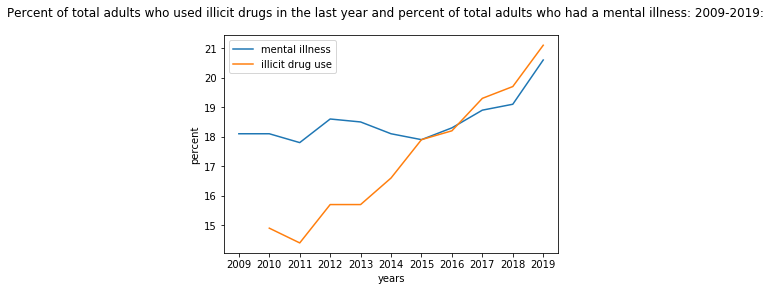

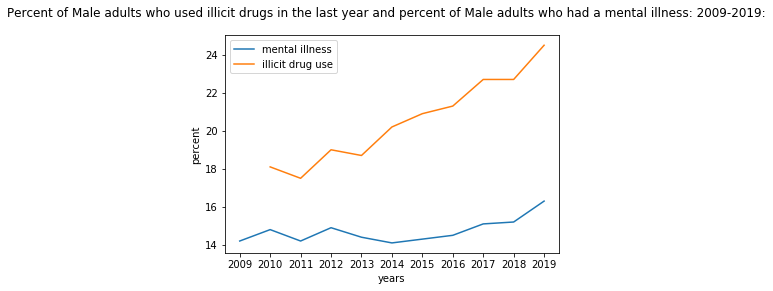

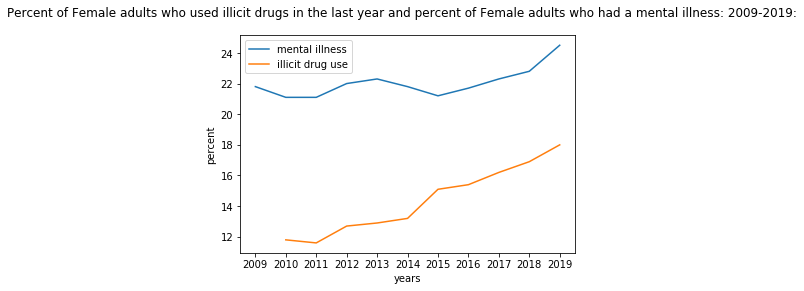

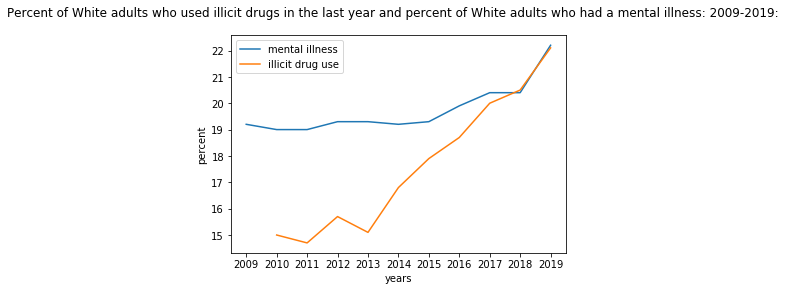

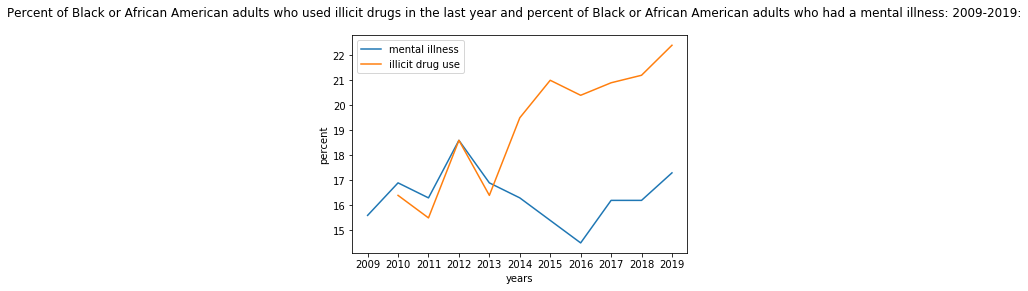

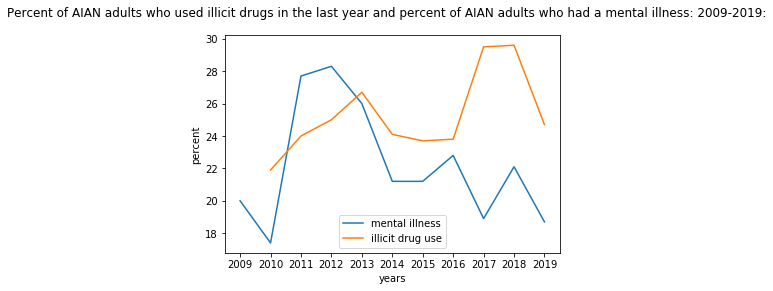

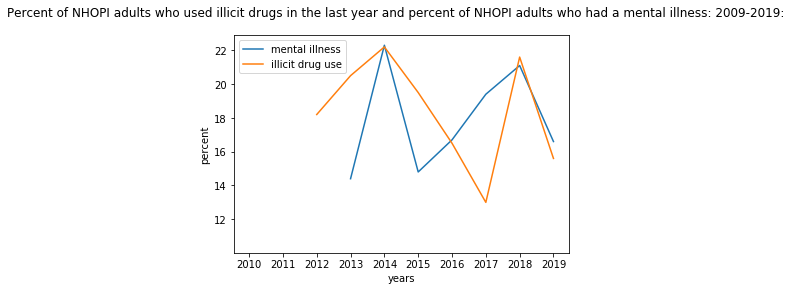

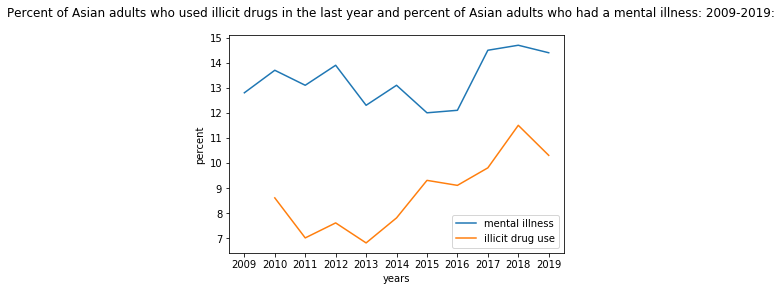

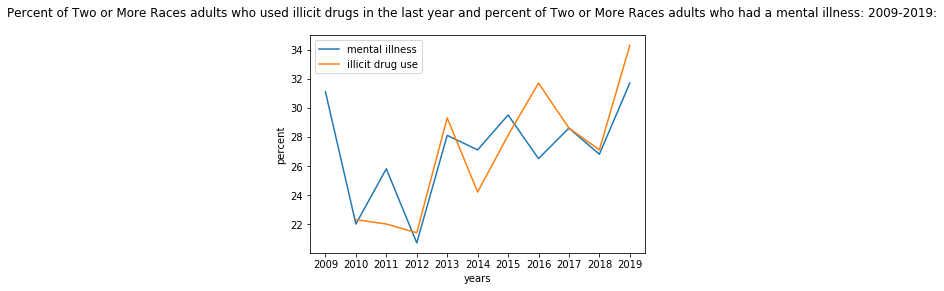

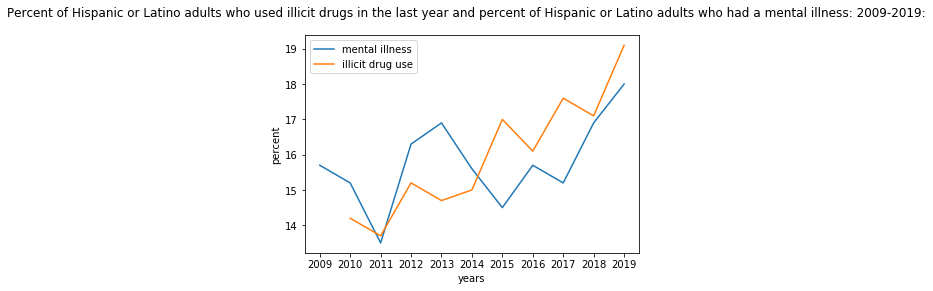

In [69]:
col_names1 = df7.columns.values.tolist()
n=0
for name in col_names1:
    fig = plt.figure(n)
    plt.plot(df2[name][1:], label = 'mental illness')
    plt.plot(df7[name][1:], label='illicit drug use')
    plt.xlabel('years')
    plt.ylabel('percent')
    fig.suptitle('Percent of '+ name + ' adults who used illicit drugs in the last year and percent of ' + name + ' adults who had a mental illness: 2009-2019:')
    plt.legend()
    plt.show()
    n+=1

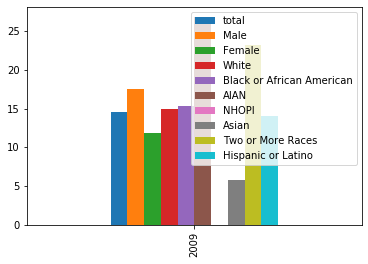

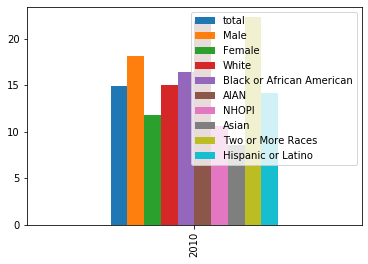

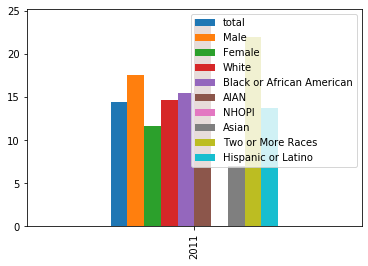

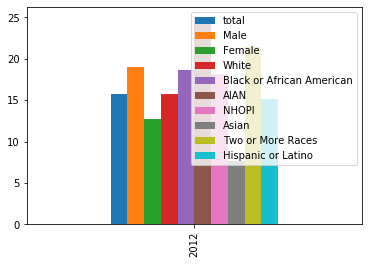

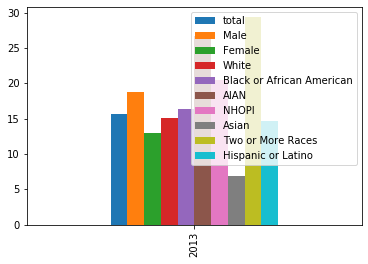

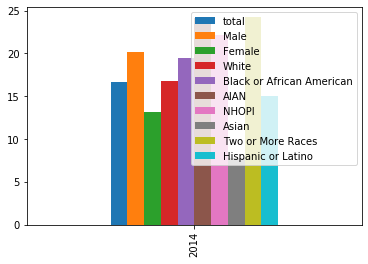

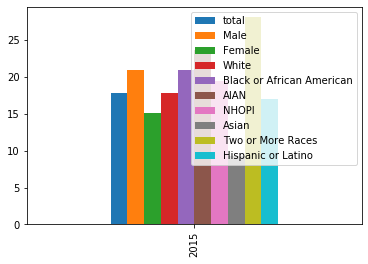

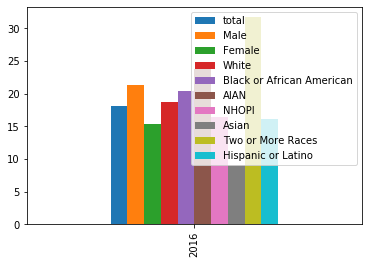

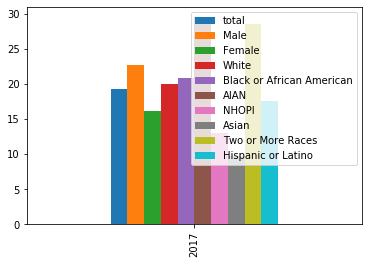

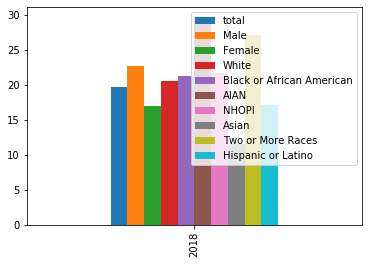

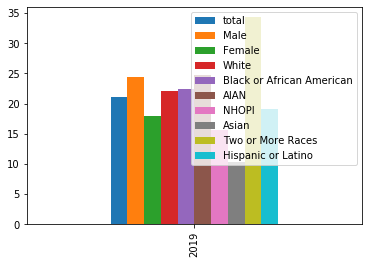

In [70]:
drug_bar = df7.groupby(by=years1[1:])
drug_bar.plot.bar()
plt.show()

Below, we investigate the relationship between the percent of illicit drug use by racial identities and the percent of mental illnesses by racial identities for each year between 2009 and 2019.

In [147]:
explode = (0, 0, 0, 0, 0, 0, 0)
labels = ['White', 'Black or African American', 'AIAN', 'NHOPI', 'Asian', 'Two or More Races', 'Hispanic or Latino'] 
for year in years1[1:]:
    labels_plotted = labels.copy()
    wedge_sizes = []

    for race in labels:
        size = df2.loc[year][race]
        wedge_sizes.append(size)
        
    if not df2[year].hasnan():
        plt.pie(wedge_sizes, explode=explode, labels=labels_plotted)
        plt.show()

KeyError: '2009'

### B. Illicit Drug Use and Mental Illness by Geographic and Socioeconomic Characteristics

Below,  investigate the relationship between the percent of illicit drug use by demographic and the percent of mental illnesses by demographic between 2009 and 2019 by exploring the correlation between the two for all demographics and visualizing the data using plots.

In [128]:
col_names2 = df_geosoc_drug.columns.values.tolist()
for name in col_names2:
    if name in df_geosoc.columns:
        print(name)
        correlation = df_geosoc_drug[name].astype('float64').corr(df_geosoc[name].astype('float64'))
        print('Correlation between the percent of ' + name + ' individuals age 12 or older who used illicit drugs in the past year by vs. percent of ' + name + ' individuals age 12 or older who had a mental illness between 2009-2019:' + str(round(correlation, 2))+'\n')







total
Correlation between the percent of total individuals age 12 or older who used illicit drugs in the past year by vs. percent of total individuals age 12 or older who had a mental illness between 2009-2019:0.79

Large Metro
Correlation between the percent of Large Metro individuals age 12 or older who used illicit drugs in the past year by vs. percent of Large Metro individuals age 12 or older who had a mental illness between 2009-2019:0.64

Small Metro
Correlation between the percent of Small Metro individuals age 12 or older who used illicit drugs in the past year by vs. percent of Small Metro individuals age 12 or older who had a mental illness between 2009-2019:0.78

Nonmetro
Correlation between the percent of Nonmetro individuals age 12 or older who used illicit drugs in the past year by vs. percent of Nonmetro individuals age 12 or older who had a mental illness between 2009-2019:0.47

Urbanized
Correlation between the percent of Urbanized individuals age 12 or older who used

total


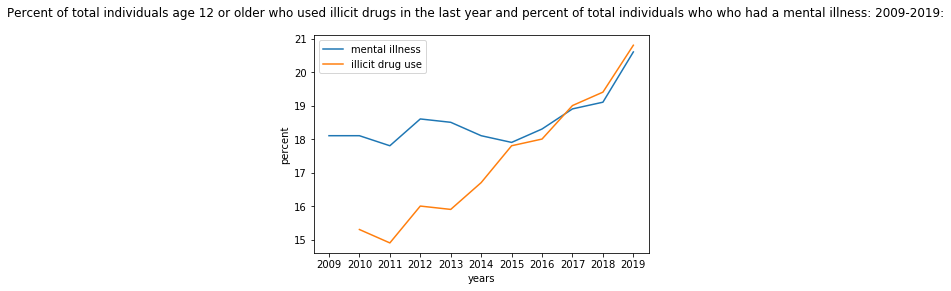

Large Metro


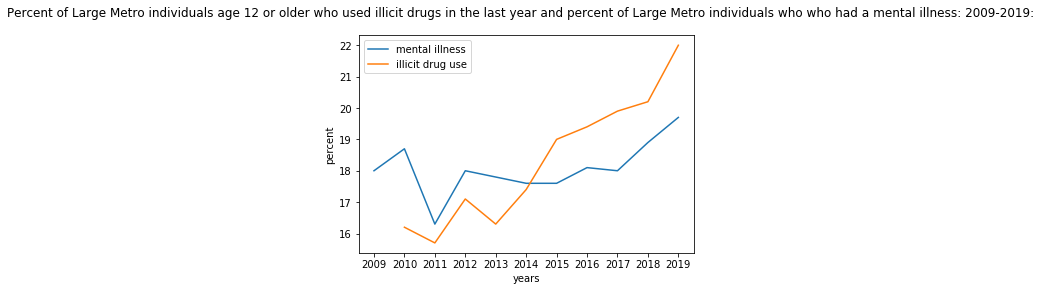

Small Metro


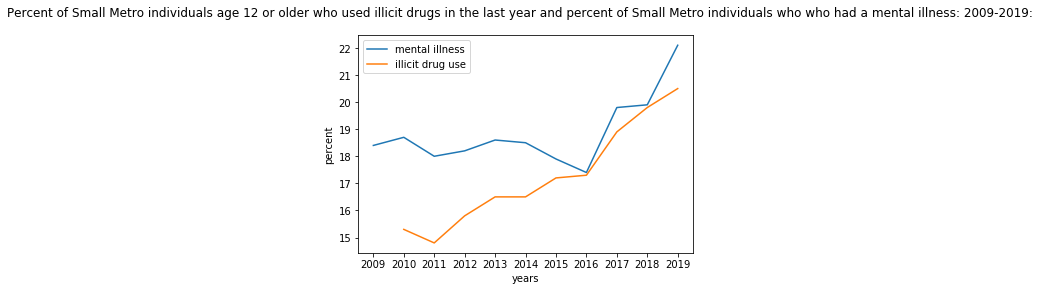

Nonmetro


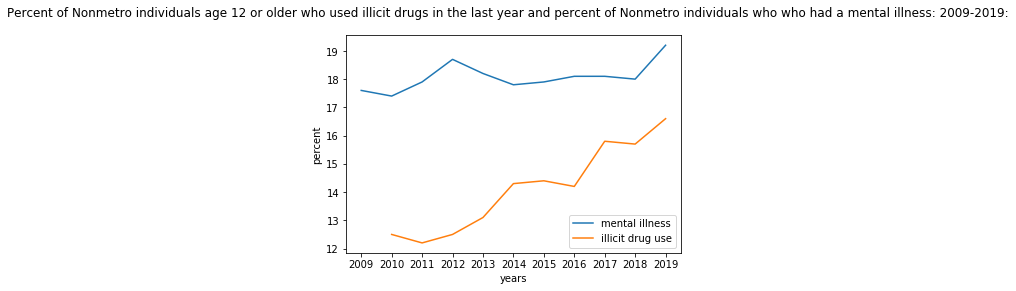

Urbanized


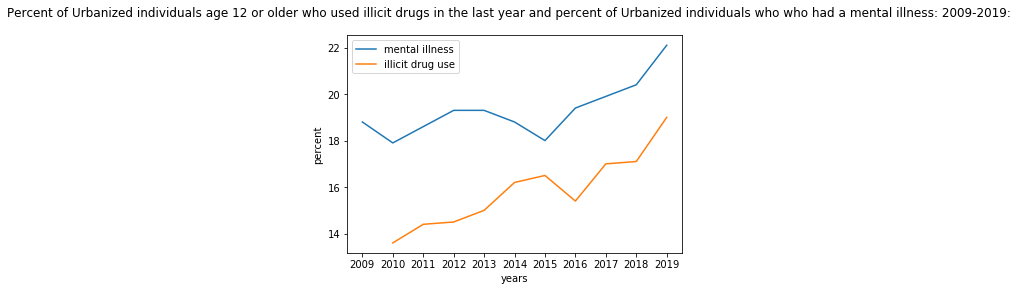

Less Urbanized


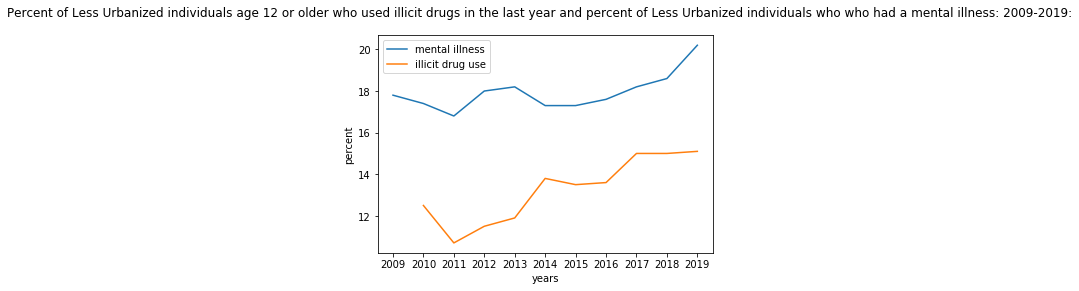

Completely Rural


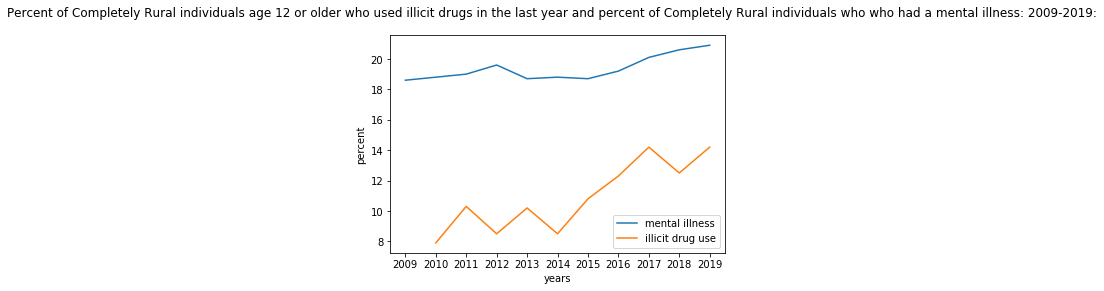

200% or More


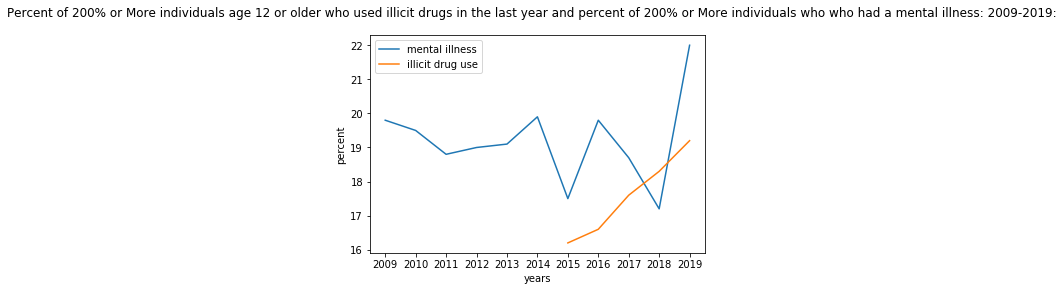

Private


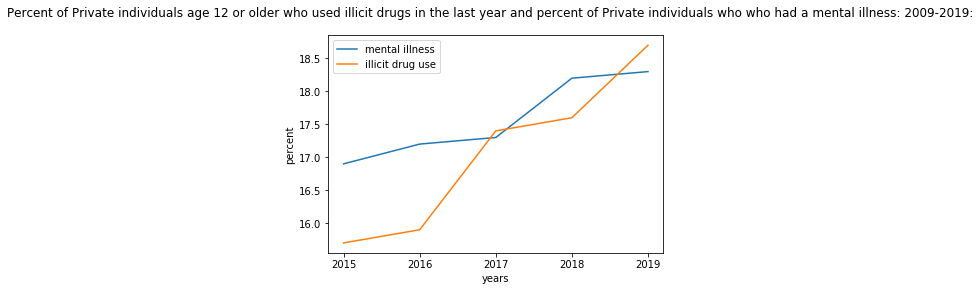

Medicaid/CHIP


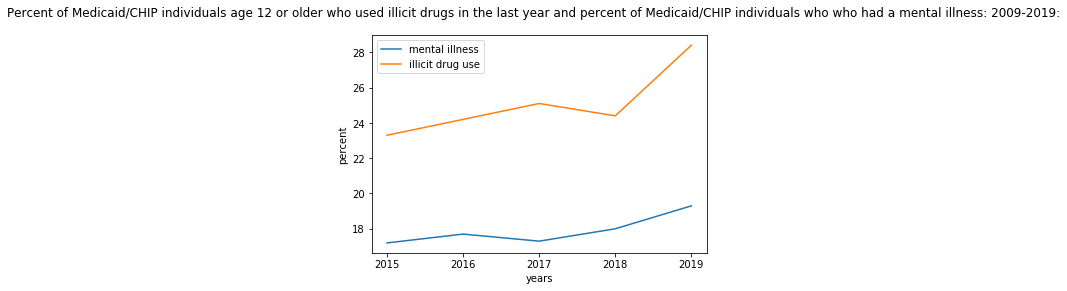

No Coverage


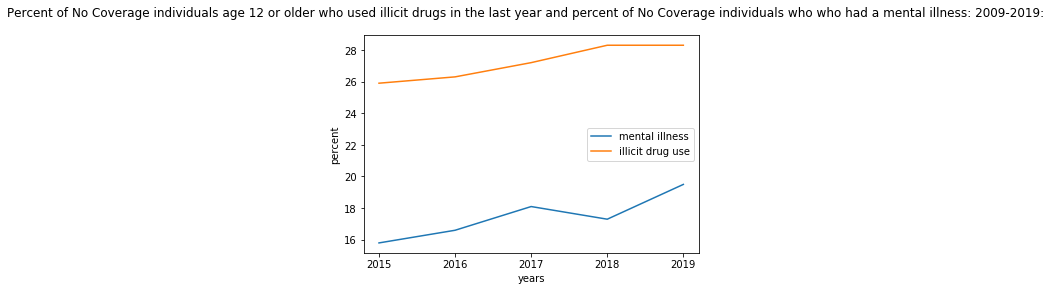

In [129]:
col_names2 = df_geosoc_drug.columns.values.tolist()
n=0
for name in col_names2:
    if name in df_geosoc.columns:
        print(name)
        fig2 = plt.figure(n)
        plt.plot(df_geosoc[name][1:], label = 'mental illness')
        plt.plot(df_geosoc_drug[name][1:], label='illicit drug use')
        plt.xlabel('years')
        plt.ylabel('percent')
        fig2.suptitle('Percent of '+ name + ' individuals age 12 or older who used illicit drugs in the last year and percent of ' + name + ' individuals who who had a mental illness: 2009-2019:')
        plt.legend()
        plt.show()
        n+=1

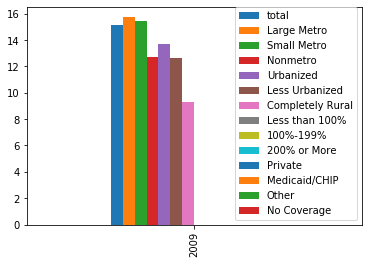

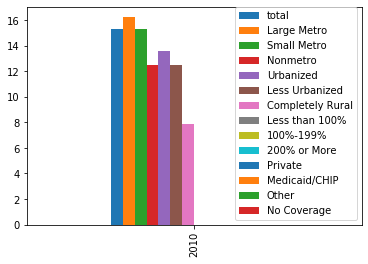

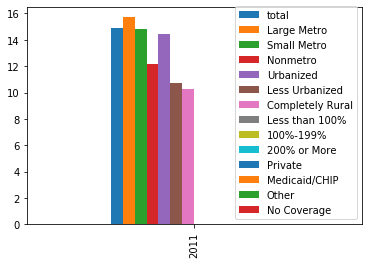

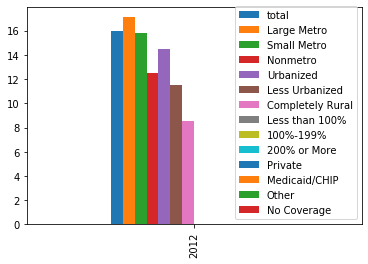

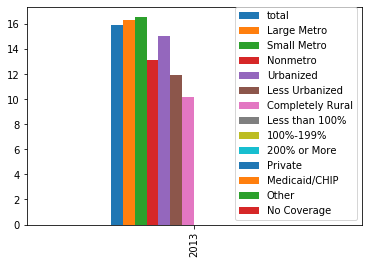

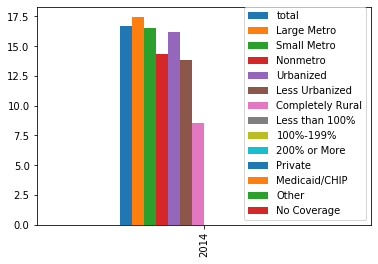

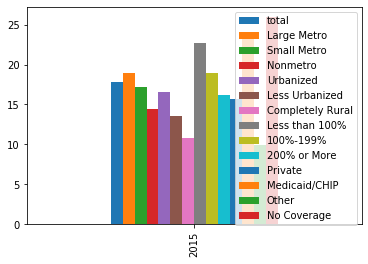

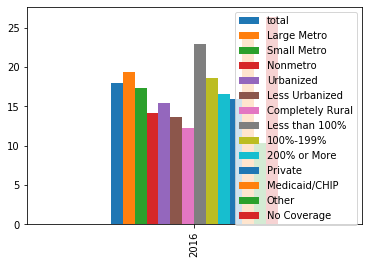

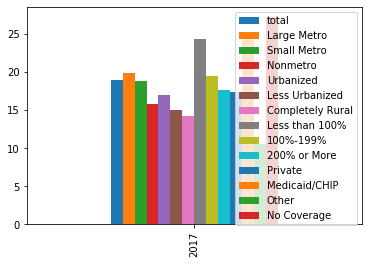

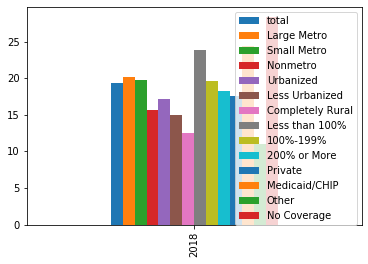

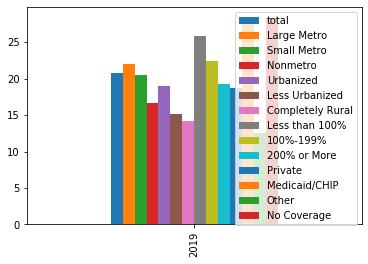

In [130]:
drug_bar2 = df_geosoc_drug.groupby(by=years1[1:])
drug_bar2.plot.bar()
plt.show()

## IV. Data Description

What are the observations (rows) and the attributes (columns)?
Why was this dataset created?
Who funded the creation of the dataset?
What processes might have influenced what data was observed and recorded and what was not?
What preprocessing was done, and how did the data come to be in the form that you are using?
If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?
Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted in a Cornell Google Drive or Cornell Box). 


Motivation:
For what purpose was the dataset created? 

With increasing public awareness of social injustice in our insitutions such as systemic racism and systemic poverty, this dataset was created to explore the relationship between socio-demographic factors, incidence of mental illness, and incidence of illicit drug use over time, particularly with the motivation to uncover evidence that incidence mental illness is significantly tied to factors influenced by social injustice. 

The data in this dataset comes from multiple U.S. National Surveys of Drug Use and Health (NSDUH) from different years, which are provided and funded by the national organization known as Substance Abuse and Mental Health Services Administration (SAMHSA). SAMHSA collected this data with the aim of helping to identify the extent of substance use and mental illness among different subgroups, estimate trends over time, and determine the need for treatment services.


Composition:
What do the instances that comprise the dataset represent?

The observations (or rows) of most of the DataFrames in this dataset represent either a single year or an age demographic category and the attributes (or columns) represent various demographic, geographic, and socioeconomic factors. The values at the intersections of these two variable typically represet either inicidence of mental illness or incidence of illicit drug usd as percentages and show some kind of relationship between all the variables. 

Some of the data related to considerations of geographic and socioeconomic factors on illicit drug use were missing for years prior to the year 2013. 


Collection Process:
The data in this dataset was collected by the Federal Government that has conducted the survey since 1971. Over the years, the survey has undergone a series of changes. In 1999, the survey shifted from paper-and-pencil data collection to computer-assisted interviewing (CAI). With CAI, staff administer most questions with audio computer-assisted self-interviewing. This provides a confidential way to answer questions and encourages honest responses

Preprocessing/Cleaning/Labeling:

Uses:

Distribution: 

Maintenance:

Impact and Challenges:

## V. Data Limitations

## VI. Questions for Reviewers

1. Can you give more clarification on what is an example of a good research question? Would it be something more broadly applicable and relating to the real-world or are statistical questions like "Does a correlation exist" suffice?

2. Our main motivation behind this dataset was to find relationship between incidence of mental illness and socio-demographic factors that reflect social justice issues but we came across. What are some creative ways that we could incorporate illict drug use into analysis about mental health?
